<a href="https://colab.research.google.com/github/solislemuslab/colonization-squid/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [4]:
! pip install phenograph

     |████████████████████████████████| 163kB 7.1MB/s 
     |████████████████████████████████| 2.4MB 9.5MB/s 
     |████████████████████████████████| 27.4MB 135kB/s 
     |████████████████████████████████| 3.1MB 38.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
import phenograph
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [6]:
SEED = 100
categories = [1,2,3,4,5,6]

data_path = '/content/gdrive/My Drive/squid/'
squid = pd.read_excel(data_path+'Dataset-S1.xlsx')
squid.shape

(3983, 31)

In [7]:
X, Y = squid.drop(['Category'], axis=1), squid.Category
xtrain_full, xtest, ytrain_full, ytest = \
  train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
xtrain, xval, ytrain, yval = \
  train_test_split(xtrain_full, ytrain_full, test_size=0.15, random_state=SEED, stratify=ytrain_full)
print(f'Shape: Training {xtrain.shape[0]}, Validation {xval.shape[0]}, Test {xtest.shape[0]}')

Shape: Training 2708, Validation 478, Test 797


In [8]:
def get_avg(df):
  df['input_avg'] = df[input_col_list].mean(axis=1)
  df['lbs_avg'] = df[lbs_col_list].mean(axis=1)

def get_col_list(start=1, stop=11, verbal=False):
  res = []
  for i in range(start,stop):
    s = 'Input' 
    if i < 10:
      s += '0'
    s += str(i)
    res.append(s)
  if verbal:
    print(res)
  return res

input_col_list = get_col_list(verbal=False)
lbs_col_list = get_col_list(1,2)
get_avg(xtrain)
get_avg(xval)
get_avg(xtest)
agg_list = ['Locus_Tag','input_avg','lbs_avg','Squid01_1','Squid02_1','Squid03_1','Squid04_1','Squid05_1','Squid06_1']
xtrain_input_avg = xtrain[agg_list].copy()
xval_input_avg = xval[agg_list].copy()
xtest_input_avg = xtest[agg_list].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
numerate_cols = ['input_avg','lbs_avg','Squid01_1','Squid02_1','Squid03_1','Squid04_1','Squid05_1','Squid06_1']

In [10]:
def phenographInfo(arr):
    print("data size", arr.shape)
    print("different clusters and their sizes", np.unique(arr, return_counts=True))

def getConfMat(label, community):
    print("The AMI score is", np.round(adjusted_mutual_info_score(label, community),3))
    conf_mat = pd.crosstab(label, community)
    conf_mat = conf_mat.div(conf_mat.sum(axis=1), axis=0)
    return conf_mat

def plotConfMat(conf_mat, figsize=(8,6), title="", fontsize=20, xlabel="Cluster"):
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(conf_mat, ax=ax, annot=True, cbar=False, \
            cmap=sns.diverging_palette(240,10,as_cmap=True), \
            fmt='.1%', vmax=1)
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0, .25, .5, 0.75, 1.])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel)

In [11]:
xval_input_avg.head(2)

,Locus_Tag,input_avg,lbs_avg,Squid01_1,Squid02_1,Squid03_1,Squid04_1,Squid05_1,Squid06_1
767,VF_0735,115.068874,118.875588,2.290694,196.867837,540.627558,74.094922,1747.669853,111.936416
3340,VF_A0595,0.048155,0.000000,0.000000,0.000000,0.332438,0.000000,0.000000,0.000000


Even though I set a fixed random seed, it is not guarantee every time the algorithm will generate the same result. It might be a little bit different, but won't produce huge difference

In [12]:
pheno_communities_avg, graph_avg, Q_avg = phenograph.cluster(data=xtrain_input_avg[numerate_cols], k=30, primary_metric='euclidean', seed=SEED)
phenographInfo(pheno_communities_avg)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11869955062866211 seconds
Jaccard graph constructed in 1.238943099975586 seconds
Wrote graph to binary file in 0.26211071014404297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.867219
After 16 runs, maximum modularity is Q = 0.868293
Louvain completed 36 runs in 1.3409881591796875 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.1206395626068115 seconds
data size (2708,)
different clusters and their sizes (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([285, 232, 224, 213, 193, 184, 178, 177, 165, 138, 133, 112, 111,
       104,  94,  93,  72]))


The AMI score is 0.349


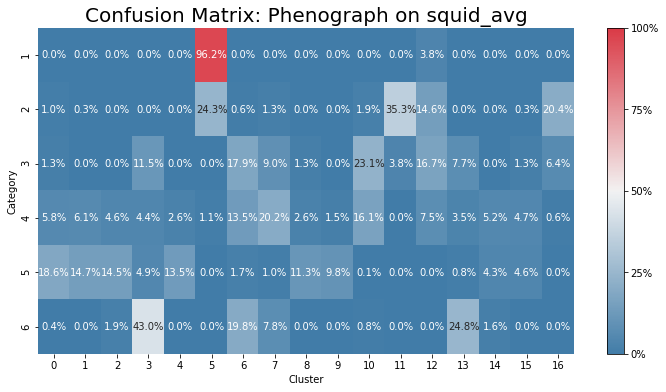

In [13]:
conf_mat_avg = getConfMat(ytrain, pheno_communities_avg)
plotConfMat(conf_mat_avg, figsize=(12,6), title="Confusion Matrix: Phenograph on squid_avg")

In [14]:
xtrain_input_avg['pheno_community'] = pheno_communities_avg

The AMI score is 0.358


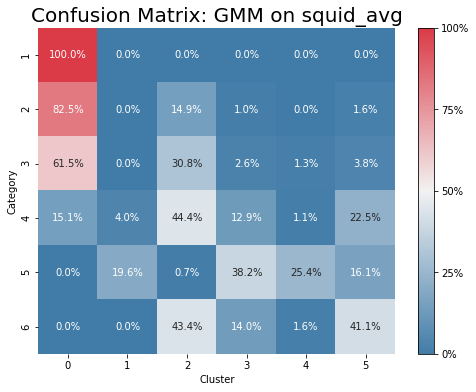

In [15]:
gmm = GaussianMixture(n_components=6, n_init=3, random_state=SEED)
gmm.fit(xtrain_input_avg[numerate_cols])
gmm_communities_avg = gmm.predict(xtrain_input_avg[numerate_cols])
conf_mat_gmm_avg = getConfMat(ytrain, gmm_communities_avg)
plotConfMat(conf_mat_gmm_avg, figsize=(8,6), title="Confusion Matrix: GMM on squid_avg")

In [16]:
xtrain_input_avg['gmm_community'] = gmm_communities_avg
xtrain_input_avg.head()

,Locus_Tag,input_avg,lbs_avg,Squid01_1,Squid02_1,Squid03_1,Squid04_1,Squid05_1,Squid06_1,pheno_community,gmm_community
1601,VF_1531,289.778293,300.349470,307.239338,0.763900,17.951661,0.678732,27.530611,13.929119,2,5
1412,VF_1354,238.813306,238.634756,17.466542,1587.819861,51.278586,1008.369672,36.770989,53.199166,4,4
529,VF_0514,120.086099,131.993363,19.375454,19.643132,478.461622,4.298637,790.671524,33.899784,8,3
1629,VF_1558,213.381174,208.796916,12.598817,13.641064,355.542613,8.031663,27.244826,48.332366,15,3
3624,VF_A0876,17.992808,22.837163,2.672476,0.000000,0.914205,1.470586,3.619942,6.209366,10,2


In [17]:
path = data_path + 'xtrain_input_avg.csv'
xtrain_input_avg.to_csv(path)

In [ ]:
df_tmp = xtrain_input_avg[(xtrain_input_avg['pheno_community']==6) & (xtrain_input_avg['gmm_community']==0)]
print(f'The size of the intersection is {df_tmp.shape[0]}')
df_tmp.head()

The size of the intersection is 183


,Locus_Tag,input_avg,lbs_avg,Squid01_1,Squid02_1,Squid03_1,Squid04_1,Squid05_1,Squid06_1,pheno_community,gmm_community
804,VF_T0039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
2595,VF_2658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
127,VF_0127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
1226,VF_1169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
3410,VF_A0664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0


The AMI score is 0.097


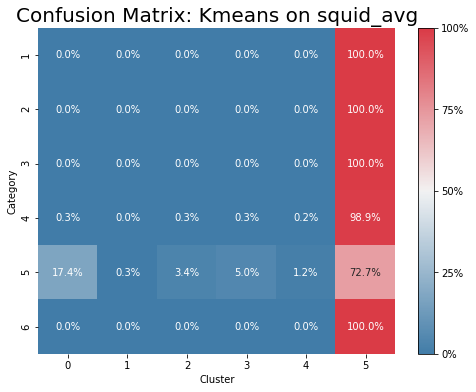

In [ ]:
km = KMeans(n_clusters=6, random_state=SEED)
km.fit(xtrain_input_avg)
km_communities_avg = km.predict(xtrain_input_avg)
conf_mat_km_avg = getConfMat(ytrain, km_communities_avg)
plotConfMat(conf_mat_km_avg, figsize=(8,6), title="Confusion Matrix: Kmeans on squid_avg")